# Real and AI-Generated Synthetic Images #

## Motivation: ##

In our pursuit of knowledge and innovation, we embark on a compelling journey to harness the power of deep learning. Our primary objective is to develop a robust model capable of distinguishing between authentic, real-world images and those generated by artificial intelligence. This endeavor is fueled by an unwavering curiosity, aimed at pushing the boundaries of computer vision and exploring its practical applications in content validation and image forensics.

The rapid advancement in the quality of AI-generated images has sparked concerns regarding their authenticity and reliability. As such, our project takes center stage in addressing this critical issue.

At the core of our research lies CIFAKE, a meticulously curated dataset comprising 60,000 synthetic images and an equivalent number of genuine images sourced from CIFAR-10. It serves as the linchpin for our exploration into the depths of computer vision and its capabilities.

We pose a fundamental question: Can computer vision techniques be harnessed to reliably discern the origin of an image, distinguishing between those created by human hands and those crafted by artificial intelligence? Our journey is driven by the pursuit of an answer to this inquiry, offering the potential to reshape the way we interact with, evaluate, and trust the images that permeate our digital world

## Import libraries ##

Import essential libraries that are necessary for our project and se hyperparameters

In [ ]:
import os
import random
from IPython.display import Image, display
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
SEED = 42
NUM_EPOCHS = 5
def PRINT() -> None: print('-' *90)

## Setting device agnostic code ##

In [ ]:
# Setup device-agnostic code
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Let's ascertain the `GPU` being utilized for this project.

In [ ]:
!nvidia-smi

Sat Nov 11 16:23:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data ##

First step is to get the data, which is real images and fake images generated by AI.

Also visualize some information about our data.

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Real_And_AI_Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
from pathlib import Path

train_dir_path = Path('/content/train')
test_dir_path = Path('/content/test')


In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    PRINT()
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
  PRINT()

In [ ]:
walk_through_dir(train_dir_path)
walk_through_dir(test_dir_path)

------------------------------------------------------------------------------------------
There are 2 directories and 0 images in '/content/train'.
------------------------------------------------------------------------------------------
There are 0 directories and 50000 images in '/content/train/REAL'.
------------------------------------------------------------------------------------------
There are 0 directories and 50000 images in '/content/train/FAKE'.
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
There are 2 directories and 0 images in '/content/test'.
------------------------------------------------------------------------------------------
There are 0 directories and 10000 images in '/content/test/REAL'.
------------------------------------------------------------------------------------------
There are 0 directories and 10000 images in '/co

In [ ]:
# Setup train and testing paths
train_dir_real = train_dir_path / "REAL"
train_dir_fake = train_dir_path / "FAKE"

test_dir_real = test_dir_path / "REAL"
test_dir_fake = test_dir_path / "FAKE"

PRINT()
print(train_dir_real , train_dir_fake)
PRINT()
print(test_dir_real , test_dir_fake)
PRINT()

------------------------------------------------------------------------------------------
/content/train/REAL /content/train/FAKE
------------------------------------------------------------------------------------------
/content/test/REAL /content/test/FAKE
------------------------------------------------------------------------------------------


## Data Exploration ##

### Visualize images from train dataset ###

The next step is to visualize two images with their labels. One of the images will be salected from the `FAKE` images, and the second from the `REAL` images.

------------------------------------------------------------------------------------------
The original height of all the images -> 32 and width -> 32
------------------------------------------------------------------------------------------
For better visualization of the images, resize them to -> (512,512) [H,W]
------------------------------------------------------------------------------------------


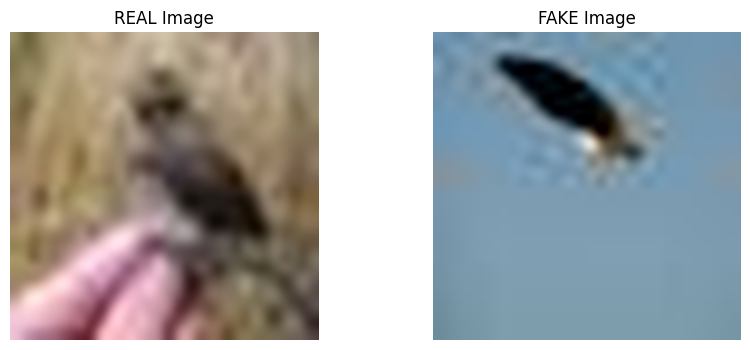

In [ ]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list_real = list(train_dir_real.glob("* (*).jpg"))
image_path_list_fake = list(train_dir_fake.glob("* (*).jpg"))

# 2. Get random image paths
random_image_path_real = random.choice(image_path_list_real)
random_image_path_fake = random.choice(image_path_list_fake)

# 3. Get image classes from path names (the image class is the name of the directory where the image is stored)

real_image_class = random_image_path_real.parent.stem
fake_image_class = random_image_path_fake.parent.stem

# 4. Open and resize images
random_im = Image.open(random_image_path_real)
PRINT()
print(f'The original height of all the images -> {random_im.height} and width -> {random_im.width}')
PRINT()

real_img = np.asarray(Image.open(random_image_path_real).resize((512, 512), Image.LANCZOS))
fake_img = np.asarray(Image.open(random_image_path_fake).resize((512, 512), Image.LANCZOS))

print(f'For better visualization of the images, resize them to -> (512,512) [H,W]')
PRINT()
# 5. Create a figure with two subplots
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)  #first subplot
plt.title(real_image_class + ' Image')
plt.imshow(real_img)
plt.axis('off')

plt.subplot(1, 2, 2)  #second subplot
plt.title(fake_image_class + ' Image')
plt.imshow(fake_img)
plt.axis('off')

plt.show()

### Transforming the data ###

The next step is to load our image data into PyTorch.

For that, we need to take two steps:

* Turn in into `tensors` (numerical representations of our images)

* Turn into into `torchvision.datasets` and subsequently a `torch.utils.data.DataLoader`

Furthermore, we'll need `torchvision.transforms` for preparing our data.

*Note ->* for more about transforming and augmenting images :

 https://pytorch.org/vision/stable/transforms.html

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2

In [ ]:
data_transform = v2.Compose([v2.Resize(size=(256,256)),
                             v2.RandomHorizontalFlip(p=0.5),
                             v2.ToImage(),
                             v2.ToDtype(torch.float32, scale=True)
                              ])

#### Loading image data using `ImageFolder` ####

The next step is to turn the image data into a `Dataset` capable of being uset with PyTorch.

We can do so by using `torch.torchvision.datasets.ImageFolder()`.


In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir_path, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir_path,
                                 transform=None)


In [ ]:
PRINT()
print(f"Train data:\n {'-' *80} \n{train_data}\n {'-' *80} \nTest data:\n {'-' *80} \n{test_data}\n {'-' *80}")

------------------------------------------------------------------------------------------
Train data:
 -------------------------------------------------------------------------------- 
Dataset ImageFolder
    Number of datapoints: 100000
    Root location: /content/train
    StandardTransform
Transform: Compose(
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 RandomHorizontalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
           )
 -------------------------------------------------------------------------------- 
Test data:
 -------------------------------------------------------------------------------- 
Dataset ImageFolder
    Number of datapoints: 20000
    Root location: /content/test
 --------------------------------------------------------------------------------


The next step is to create data structure that hold classes names, which `FAKE` for AI generated image and `REAL` for real human takes image.

In [ ]:
class_names = train_data.classes
NUM_CLASSES = len(class_names)

class_names

['FAKE', 'REAL']

In [ ]:
print(f"{'-'*80}\n The are [{len(train_data)}] images in train_data and [{len(test_data)}] images in test_data \n {'-' *80}")


--------------------------------------------------------------------------------
 The are [100000] images in train_data and [20000] images in test_data 
 --------------------------------------------------------------------------------


We can index on our `train_data` and `test_data` Dataset's to find samples and their target labels.



In [ ]:
img, label = train_data[60000][0], train_data[60000][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
Image([[[0.8392, 0.8392, 0.8392,  ..., 0.2627, 0.2627, 0.2627],
        [0.8392, 0.8392, 0.8392,  ..., 0.2627, 0.2627, 0.2627],
        [0.8392, 0.8392, 0.8392,  ..., 0.2627, 0.2627, 0.2627],
        ...,
        [0.2314, 0.2314, 0.2314,  ..., 0.4588, 0.4588, 0.4588],
        [0.2314, 0.2314, 0.2314,  ..., 0.4588, 0.4588, 0.4588],
        [0.2314, 0.2314, 0.2314,  ..., 0.4588, 0.4588, 0.4588]],

       [[0.7529, 0.7529, 0.7529,  ..., 0.2706, 0.2706, 0.2706],
        [0.7529, 0.7529, 0.7529,  ..., 0.2706, 0.2706, 0.2706],
        [0.7529, 0.7529, 0.7529,  ..., 0.2706, 0.2706, 0.2706],
        ...,
        [0.2196, 0.2196, 0.2196,  ..., 0.4353, 0.4353, 0.4353],
        [0.2196, 0.2196, 0.2196,  ..., 0.4353, 0.4353, 0.4353],
        [0.2196, 0.2196, 0.2196,  ..., 0.4353, 0.4353, 0.4353]],

       [[0.5569, 0.5569, 0.5569,  ..., 0.2275, 0.2275, 0.2275],
        [0.5569, 0.5569, 0.5569,  ..., 0.2275, 0.2275, 0.2275],
        [0.5569, 0.5569, 0.5569,  ..., 0.2275, 0.2275, 0.227

#### Create a function to display random images ####

One more step to visualize our data set will be creating a function that takes data set, list of class names and few more inputs to display number of images.

In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None) -> None:

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

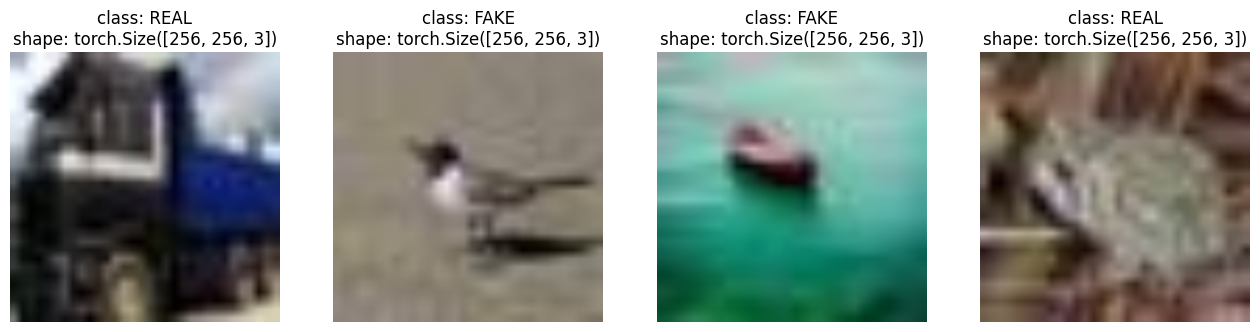

In [ ]:
# Visualize few images using function

display_random_images(train_data, train_data.classes, 4, True, 42 )

#### Turn loaded images into `DataLoader`'s ####

We've got our images as PyTorch Dataset's but now let's turn them into DataLoader's.

We'll do so using `torch.utils.data.DataLoader`.

*Note ->* Turning our Dataset's into DataLoader's makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

In [ ]:
from torch.utils.data import DataLoader
import os

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

print(f"{'-'*80}\n {train_dataloader} \n {'-' *80} \n {test_dataloader} \n {'-'*80}")

--------------------------------------------------------------------------------
 -------------------------------------------------------------------------------- 
 --------------------------------------------------------------------------------


In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
PRINT()
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
PRINT()


------------------------------------------------------------------------------------------
Image shape: torch.Size([32, 3, 256, 256]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
------------------------------------------------------------------------------------------


Now we have `DataLoader`'s that can be used in training and testing loops to train a model.

## Creating Models ##

Having acquired our dataset and conducted preliminary exploratory data analysis to gain a comprehensive understanding of the data under consideration, we are poised to commence the process of constructing machine learning models. In the context of this project, we intend to develop four distinct models, train them rigorously, and subsequently employ a systematic evaluation process to determine the optimal model for our image classification task.

### First Model ###

For the firt model, we'll create simple transformer without `data augmentation` techniques.

Moreover, we'll create new `datasets` and `DataLoader` for the first model

### Creating transformer, dataset and DataLoader for the first model ###

In [ ]:
first_model_transform = v2.Compose([
    v2.Resize(size=(128,128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

first_model_transform

Compose(
      Resize(size=[128, 128], interpolation=InterpolationMode.BILINEAR, antialias=warn)
      ToImage()
      ToDtype(scale=True)
)

In [ ]:
from torchvision import datasets
import os
from torch.utils.data import DataLoader

# Load and transform data
train_data_fm = datasets.ImageFolder(root=train_dir_path, transform=first_model_transform)
test_data_fm = datasets.ImageFolder(root=test_dir_path, transform=first_model_transform)

# Turn data into DataLoader
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_fm = DataLoader(dataset=train_data_fm,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=NUM_WORKERS)

test_dataloader_fm = DataLoader(dataset=test_data_fm,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS)

train_dataloader_fm, test_dataloader_fm

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7d285df6f1f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d285dfda920>)

#### Create first model ####

In [ ]:
class FirstModel(nn.Module):
  """
  First simple model
  """
  def __init__(self, input_shape : int, hidden_units : int, output_shape : int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*32*32,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    return(self.classifier(self.conv_block_2(self.conv_block_1(x))))



In [ ]:
torch.manual_seed(SEED)

# Generate first model and send it to the device (e.g. gpu)
model_0 = FirstModel(input_shape=3,
                     hidden_units=10,
                     output_shape=len(train_data_fm.classes)).to(device)


print(f"{'-'*80}\n First model: \n {'-'*80} \n {model_0} \n {'-'*80}")

--------------------------------------------------------------------------------
 First model: 
 -------------------------------------------------------------------------------- 
 FirstModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=2, bias=True)
  )
) 
 ---------------------------------------------------------------------

#### Forward pass on a single model ####

The reason behind doing so is to test our model on single piece of data before moving on.

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_fm))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"{'-'*80}\nSingle image shape: {img_single.shape}")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"{'-'*80} \n Output logits:{pred}")
print(f"{'-'*80} \n Output prediction probabilities:{torch.softmax(pred, dim=1)}")
print(f"{'-'*80} \n Output prediction label:{torch.argmax(torch.softmax(pred, dim=1), dim=1)}")
print(f"{'-'*80} \n Actual label:{label_single} \n{'-'*80}  ")

--------------------------------------------------------------------------------
Single image shape: torch.Size([1, 3, 128, 128])
-------------------------------------------------------------------------------- 
 Output logits:tensor([[-0.0523,  0.0059]], device='cuda:0')
-------------------------------------------------------------------------------- 
 Output prediction probabilities:tensor([[0.4855, 0.5145]], device='cuda:0')
-------------------------------------------------------------------------------- 
 Output prediction label:tensor([1], device='cuda:0')
-------------------------------------------------------------------------------- 
 Actual label:1 
--------------------------------------------------------------------------------  


#### Use `torchinfo` to get an idea of the shapes going through our model ####

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an input_shape and returns what happens as a tensor moves through your model.

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
FirstModel                               [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 10, 128, 128]         280
│    └─ReLU: 2-2                         [1, 10, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 10, 128, 128]         910
│    └─ReLU: 2-4                         [1, 10, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 10, 64, 64]           --
├─Sequential: 1-2                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 10, 64, 64]           910
│    └─ReLU: 2-7                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 10, 64, 64]           910
│    └─ReLU: 2-9                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-10                   [1, 10, 32, 32]           --
├─Sequentia

#### Create testing and training loop functions ####

The next step is to make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer) -> Tuple[float, float]:


               # Put the model in train mode
               model.train()

               # Setup train loss and train accuracy values
               train_loss, train_acc = 0, 0

               # Loop through DataLoader data structure in batches
               for batch, (X, y) in enumerate(dataloader):
                # Send data to target device
                X, y = X.to(device), y.to(device)

                # Forward pass
                y_pred = model(X)

                # Calculate and accumulate loss
                loss = loss_fn(y_pred, y)
                train_loss += loss.item()

                # Optimizer zero grad
                optimizer.zero_grad()

                # Loss backward
                loss.backward()

                # Oprimizer step
                optimizer.step()

                # Calculate and accumulate accuracy metric across all batches
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

               # Adjust metric to get average loss and accuracy per batch
               train_loss = train_loss / len(dataloader)
               train_acc = train_acc / len(dataloader)
               return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module) -> Tuple[float,float]:

              # Put model in eval mode
              model.eval()

              # Setup test loss and test accuracy values
              test_acc, test_loss = 0, 0

              # Turn on inference context manager
              with torch.inference_mode():
                # Loop through DataLoader batches
                for batch, (X, y) in enumerate(dataloader):
                  # Sent data to target device
                  X, y = X.to(device), y.to(device)

                  # forward pass
                  test_pred_logits = model(X)

                  # calculte and accumulate loss
                  loss = loss_fn(test_pred_logits, y)
                  test_loss += loss.item()

                  # calculate and accumulate accuracy
                  test_pred_labels = test_pred_logits.argmax(dim=1)
                  test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

                # Adjust metrics to get average loss and accuracy per batch
                test_loss = test_loss / len(dataloader)
                test_acc = test_acc / len(dataloader)
                return test_loss, test_acc


#### Create `train()` function to combine `train_step()` ####

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):
  results ={"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss {train_loss:.4f} | "
        f"train_acc {train_acc:.4f} | "
        f"test_loss {test_loss:.4f} | "
        f"test_acc {test_acc:.4f} | "
    )

    # Update results dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

#### Train and evaluate FirstModel ####

In [ ]:
PRINT()
# Set random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model_0 = FirstModel(input_shape=3,
                     hidden_units=10,
                     output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_res = train(model=model_0,
                    train_dataloader=train_dataloader_fm,
                    test_dataloader=test_dataloader_fm,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS)
PRINT()
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
PRINT()

------------------------------------------------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss 0.4127 | train_acc 0.8060 | test_loss 0.3063 | test_acc 0.8737 | 
Epoch: 2 | train_loss 0.2844 | train_acc 0.8844 | test_loss 0.2882 | test_acc 0.8894 | 
Epoch: 3 | train_loss 0.2503 | train_acc 0.8997 | test_loss 0.2544 | test_acc 0.9018 | 
Epoch: 4 | train_loss 0.2341 | train_acc 0.9076 | test_loss 0.2588 | test_acc 0.8923 | 
Epoch: 5 | train_loss 0.2194 | train_acc 0.9133 | test_loss 0.2378 | test_acc 0.9111 | 
------------------------------------------------------------------------------------------
Total training time: 625.397 seconds
------------------------------------------------------------------------------------------


#### Conclusion for FirstModel ####

`FirstModel` achived `test_acc` of `~0.91` with total training time of approximately *10 minutes* for 5 epochs.

#### Plot loss and accuracy curves for visualization ####

After training our data with `FirstModel`, we can plot the taining loss and accuracy of the training dataset and testing dataset to see how `FirstModel` acts (i.e. how the model really does on the data) .

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(10, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

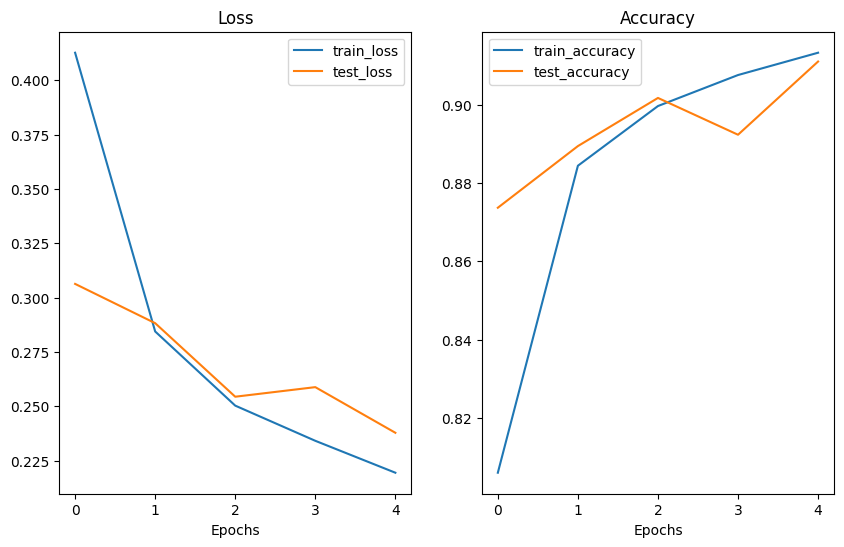

In [ ]:
plot_loss_curves(model_0_res)

#### Generate few prediction and visualize ####

The next step is to see how well `FirstModel` predicts the true label of random images.

Next steps involve generate predictions for few images, and then plot them with their predicted labels next to their real labels to see how `FirstModel` preforme.

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data_fm), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([3, 128, 128])
Test sample label: 0 (FAKE)


Next, generate predictions and transfome them into prediction labels by taking the `argmax()` of each prediction. (e.g. if the prediction of the first label is bigger than the second label, take the first label)

In [ ]:
# Make predictions on test samples with model_0
pred_probs= make_predictions(model=model_0,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[0.5003, 0.4997],
        [0.2646, 0.7354]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 1, 0, 0, 0, 1, 0, 0, 0])

Now we can plot the predictions and their labels next to their real labels to visualize our model preformance.

In [ ]:
def plot_pred(pred_classes, test_samples, test_labels,) -> None:
  # Plot predictions
  plt.figure(figsize=(9, 9))
  nrows = 3
  ncols = 3
  for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    #print(sample.permute(1, 2, 0).shape)
    plt.imshow(sample.permute(1, 2, 0) , cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

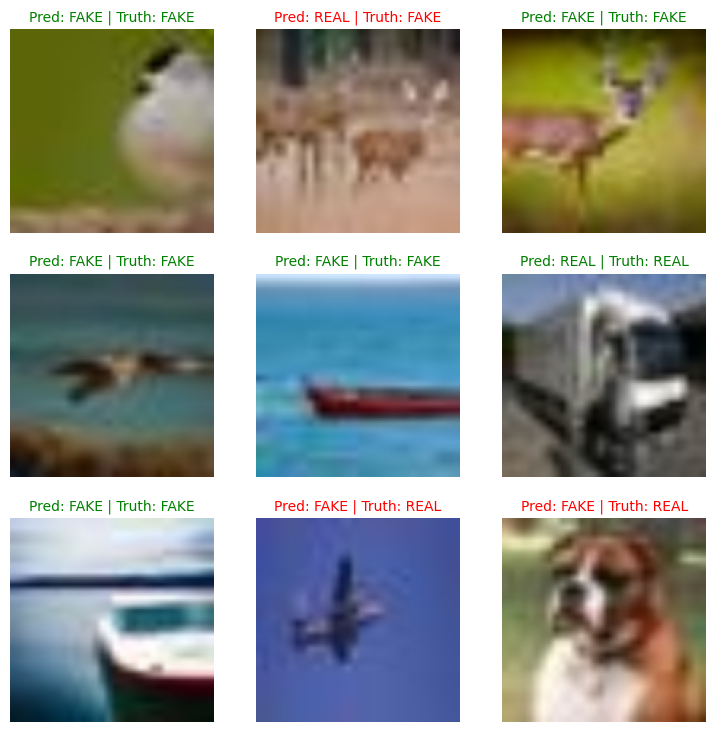

In [ ]:
plot_pred(pred_classes, test_samples, test_labels)

The first model (e.g. FirstModel) did pretty good job with `test_acc` > 0.91, also by the curves above we can see that our model learns pretty good.

Can we do better ?

### Second Model ###

For the second model, we'll use some `torchvision.model` library.

`torchvision.library` is a PyTorch library that provides pre-trained deep learning models for image-related tasks. It includes popular architectures, supports transfer learning, and allows customization for specific projects.

For our task, we'll use `ResNet50` architecture.

* ResNet-50 is a widely used deep neural network architecture for image classification. It's part of the ResNet (Residual Network) family and is known for its deep layers and skip connections, which enable training very deep networks. ResNet-50 has 50 layers and has achieved top performance in computer vision tasks.






Saving ResNet50.jpg to ResNet50.jpg


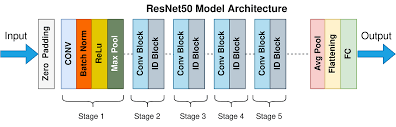

#### Creating transformer, dataset and DataLoader for the second model ####

For the second model, we'll not use data augmentation methods, just convert the images to tensors

In [ ]:
# Define the transformation for second model
second_model_transform = v2.Compose([
    v2.Resize(size=(224, 224)),  # ResNet50 typically expects 224x224 images
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

second_model_transform

Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [ ]:
# Load and transform data
train_data_sm = datasets.ImageFolder(root=train_dir_path, transform=second_model_transform)
test_data_sm = datasets.ImageFolder(root=test_dir_path, transform=second_model_transform)

# Turn data into DataLoader
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers ")

train_dataloader_sm = DataLoader(dataset=train_data_sm,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=NUM_WORKERS)
test_dataloader_sm = DataLoader(dataset=test_data_sm,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS)

train_dataloader_sm, test_dataloader_sm

Creating DataLoader's with batch size 32 and 2 workers 


(<torch.utils.data.dataloader.DataLoader at 0x7d28547d3af0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d285466baf0>)

### Create second model ###

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet50(nn.Module):
    def __init__(self, num_classes) -> None:
        super(ResNet50, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=False)

        # Replace the final classification layer
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)


In [ ]:
model_1 = ResNet50(NUM_CLASSES).to(device)

#### Visualize ResNet architecture ####

Use `summery()` method to visualize `ResNet` model architecture that we build using `ResNet50`

In [ ]:
summary(model_1, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                        Output Shape              Param #
ResNet50                                      [1, 2]                    --
├─ResNet: 1-1                                 [1, 2]                    --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

#### Train second model ####

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_res = train(model=model_1,
                        train_dataloader=train_dataloader_sm,
                        test_dataloader=test_dataloader_sm,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss 0.3025 | train_acc 0.8742 | test_loss 0.1852 | test_acc 0.9273 | 
Epoch: 2 | train_loss 0.2019 | train_acc 0.9203 | test_loss 0.2704 | test_acc 0.8862 | 
Epoch: 3 | train_loss 0.1761 | train_acc 0.9312 | test_loss 0.2027 | test_acc 0.9269 | 
Epoch: 4 | train_loss 0.1556 | train_acc 0.9395 | test_loss 0.1420 | test_acc 0.9475 | 
Epoch: 5 | train_loss 0.1411 | train_acc 0.9454 | test_loss 0.1186 | test_acc 0.9556 | 
Total training time: 2151.339 seconds


#### Conclusion for SecondModel ####

Seems like model based on `ResNet50` architecture trained for 25 minutes longer than `FirstModel`. However, `test_acc` of `ResNet50` is much greater than `FirstModel` (~0.95 compare to 0.91)

*Note:*
* The prolonged evaluation time may be attributed to the fact that we set the hyperparameter pretrained to False for `ResNet50`. Consequently, it necessitated training the model from scratch rather than utilizing the pre-trained weights. The primary motivation behind this decision was to facilitate the retrieval of parameters such as `train_acc`, `test_acc`, `train_loss`, and `test_loss`, which are not stored during the pretraining phase of `ResNet50`.

* It appears that the model undergoes continuous learning and enhancement with each epoch. Extending the training to 10 epochs might result in a significantly higher test accuracy, as the model refines its understanding of the data over successive iterations.

#### Plot loss and accuracy curves for visualization ####

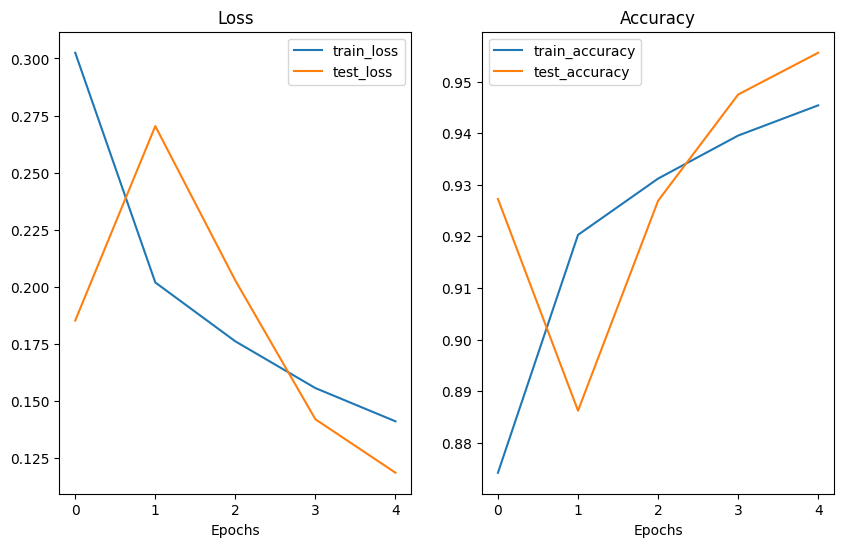

In [ ]:
plot_loss_curves(model_1_res)

### Third Model ###

The third model will be akin to `FirstModel`, with the distinction that the `datasets.ImageFolder` will incorporate *data augmentation* techniques. This augmentation is implemented to enhance the model's ability to generalize, thereby contributing to improved accuracy across the dataset.

* *Data augmentation* helps improve model generalization by exposing it to a wider range of variations in the training data, making it more robust and capable of handling diverse inputs.

#### Creating transformer, dataset and DataLoader for the third model ####

For the third model, we will employ data augmentation techniques, incorporating two specific methods:

* `v2.TrivialAugmentWide()`
* `v2.RandomHorizontalFlip()`

In [ ]:
third_model_transform = v2.Compose([v2.Resize(size=(128, 128)),
                                    v2.TrivialAugmentWide(num_magnitude_bins=31),
                                    v2.RandomHorizontalFlip(p=0.5),
                                    v2.ToTensor()]
)

third_model_transform

Compose(
      Resize(size=[128, 128], interpolation=InterpolationMode.BILINEAR, antialias=warn)
      TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=31)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
)

In order to gain a deeper insight into our data augmentation techniques, we will create a function that accepts an image path, a transformer, and the desired number of images to generate. This function will apply the data augmentation techniques contained within the transformer to the images and then display them alongside their original, unaltered versions for comparison.

In [ ]:
from PIL import Image

def plot_transformed_images(image_paths, transform, n=3) -> None :
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

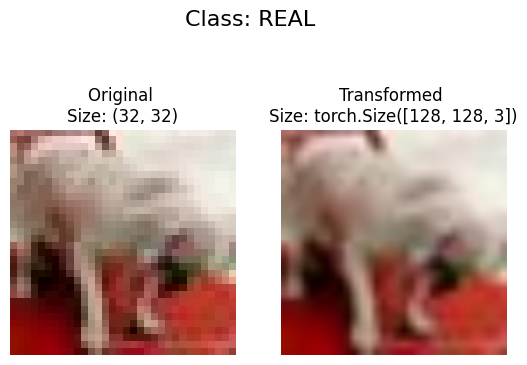

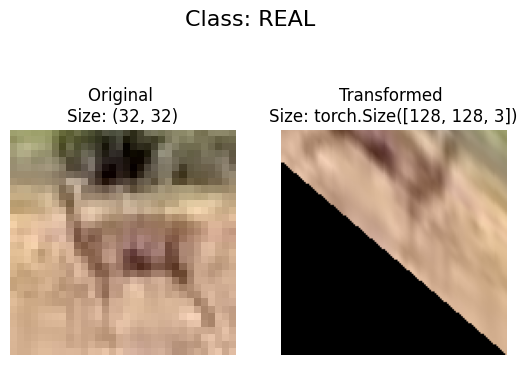

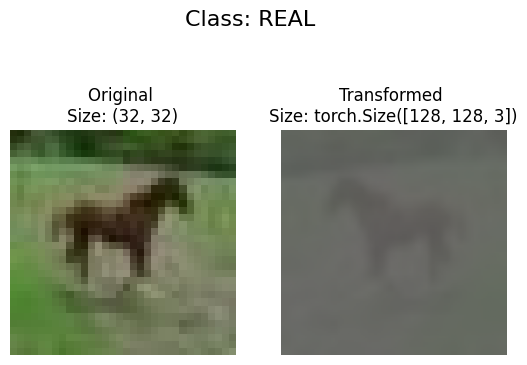

In [ ]:
plot_transformed_images(image_path_list_real,
                        transform=third_model_transform,
                        n=3)

Now, we can continue and generate `DataLoader`s :

In [ ]:
from torch.utils.data import DataLoader

# Load and transform data
train_data_tm = datasets.ImageFolder(root=train_dir_path, transform=third_model_transform)
test_data_tm = datasets.ImageFolder(root=test_dir_path, transform=third_model_transform)

# Turn data into DataLoader
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers ")

train_dataloader_tm = DataLoader(dataset=train_data_tm,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=NUM_WORKERS)
test_dataloader_tm = DataLoader(dataset=test_data_tm,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS)

train_dataloader_tm, test_dataloader_tm

Creating DataLoader's with batch size 32 and 2 workers 


(<torch.utils.data.dataloader.DataLoader at 0x7d281c983760>,
 <torch.utils.data.dataloader.DataLoader at 0x7d281be5add0>)

#### Create third model ####

In [ ]:
class ThirdModel(nn.Module):
  """
  Third model, very similar to the FirstModl
  """
  def __init__(self, input_shape : int, hidden_units : int, output_shape : int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*32*32,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    return(self.classifier(self.conv_block_2(self.conv_block_1(x))))



#### Train and evaluate third model ####

In [ ]:
print('-'*80)
# Set random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model_2 = ThirdModel(input_shape=3,
                     hidden_units=10,
                     output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_2_res = train(model=model_2,
                    train_dataloader=train_dataloader_tm,
                    test_dataloader=test_dataloader_tm,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS)
print('-'*80)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
print('-'*80)

--------------------------------------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss 0.5199 | train_acc 0.7400 | test_loss 0.4790 | test_acc 0.7697 | 
Epoch: 2 | train_loss 0.4343 | train_acc 0.8030 | test_loss 0.4236 | test_acc 0.8122 | 
Epoch: 3 | train_loss 0.4056 | train_acc 0.8198 | test_loss 0.3907 | test_acc 0.8236 | 
Epoch: 4 | train_loss 0.3865 | train_acc 0.8304 | test_loss 0.4072 | test_acc 0.8124 | 
Epoch: 5 | train_loss 0.3763 | train_acc 0.8337 | test_loss 0.3553 | test_acc 0.8458 | 
--------------------------------------------------------------------------------
Total training time: 811.367 seconds
--------------------------------------------------------------------------------


#### Conclusion for ThirdModel ####

Seems like `ThirdModel` is worse than `FirstModel` which in two categories:

* Run time - while `ThirdModel` trained in ~13 minutes, `FirstModel` trained in just 10 minutes.

* Preformeance - while `ThirdModel`'s `test_acc` is `0.84`, `FirstModel`'s is `0.91`.

The integration of data augmentation techniques did not result in an enhancement of test accuracy. It may be worthwhile to explore an extended training duration, such as 10 epochs. This prolonged training period could enable the model to better leverage the introduced data augmentation techniques, fostering improved generalization and, consequently, enhancing predictive performance, leading to an elevated test accuracy.

It appears that `SecondModel` exhibits the most impressive performance among the three models that have been trained thus far

#### Plot loss and accuracy curves for visualization ####

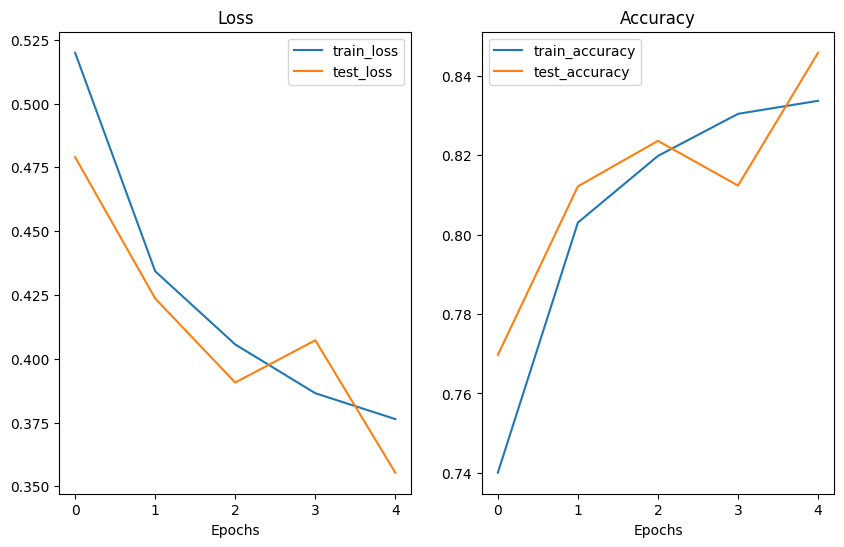

In [ ]:
plot_loss_curves(model_2_res)

#### Plotting `FirstModel` and `ThirdModel` together ####

Because `FirstModel` and `ThirdModel` are almost identical, except for the addition of features such as data augmentation and extra hidden layers in `ThirdModel`, it would be helpful to visualize both their *Loss* and *Accuracy* together in the same plot.

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_res)
model_2_df = pd.DataFrame(model_2_res)


We shall define a function that accepts dataframes containing metrics from multiple models and generates comprehensive performance plots, allowing us to assess and compare the performance of all models simultaneously. This function will prove invaluable at the project's conclusion when we aim to conduct a holistic evaluation of all models, extending beyond the comparison of just two models.

In [ ]:
import matplotlib.pyplot as plt

def plot_model_metrics(models_data, model_names=None):
    """
    Plot training and testing loss and accuracy for multiple models.

    Parameters:
    - models_data (list of dataframes): A list of dataframes, where each dataframe contains the metrics for a model.
    - model_names (list of strings, optional): A list of model names corresponding to the dataframes. If not provided, default names will be used.

    Example usage:
    - plot_model_metrics([model_0_df, model_1_df, model_2_df, model_3_df], model_names=["Model 1", "Model 2", "Model 3", "Model 4"])
    - plot_model_metrics([model_0_df, model_1_df])  # For 2 models
    """

    if not model_names:
        model_names = [f"Model {i + 1}" for i in range(len(models_data))]

    num_models = len(models_data)
    num_metrics = len(models_data[0].columns)

    # Create a 2x2 grid of subplots
    plt.figure(figsize=(15, 10))

    for i in range(num_metrics):
        plt.subplot(2, 2, i + 1)
        for j in range(num_models):
            plt.plot(range(len(models_data[j])), models_data[j].iloc[:, i], label=model_names[j])
        plt.title(models_data[0].columns[i])
        plt.xlabel("Epochs")
        plt.legend()

    plt.tight_layout()
    plt.show()


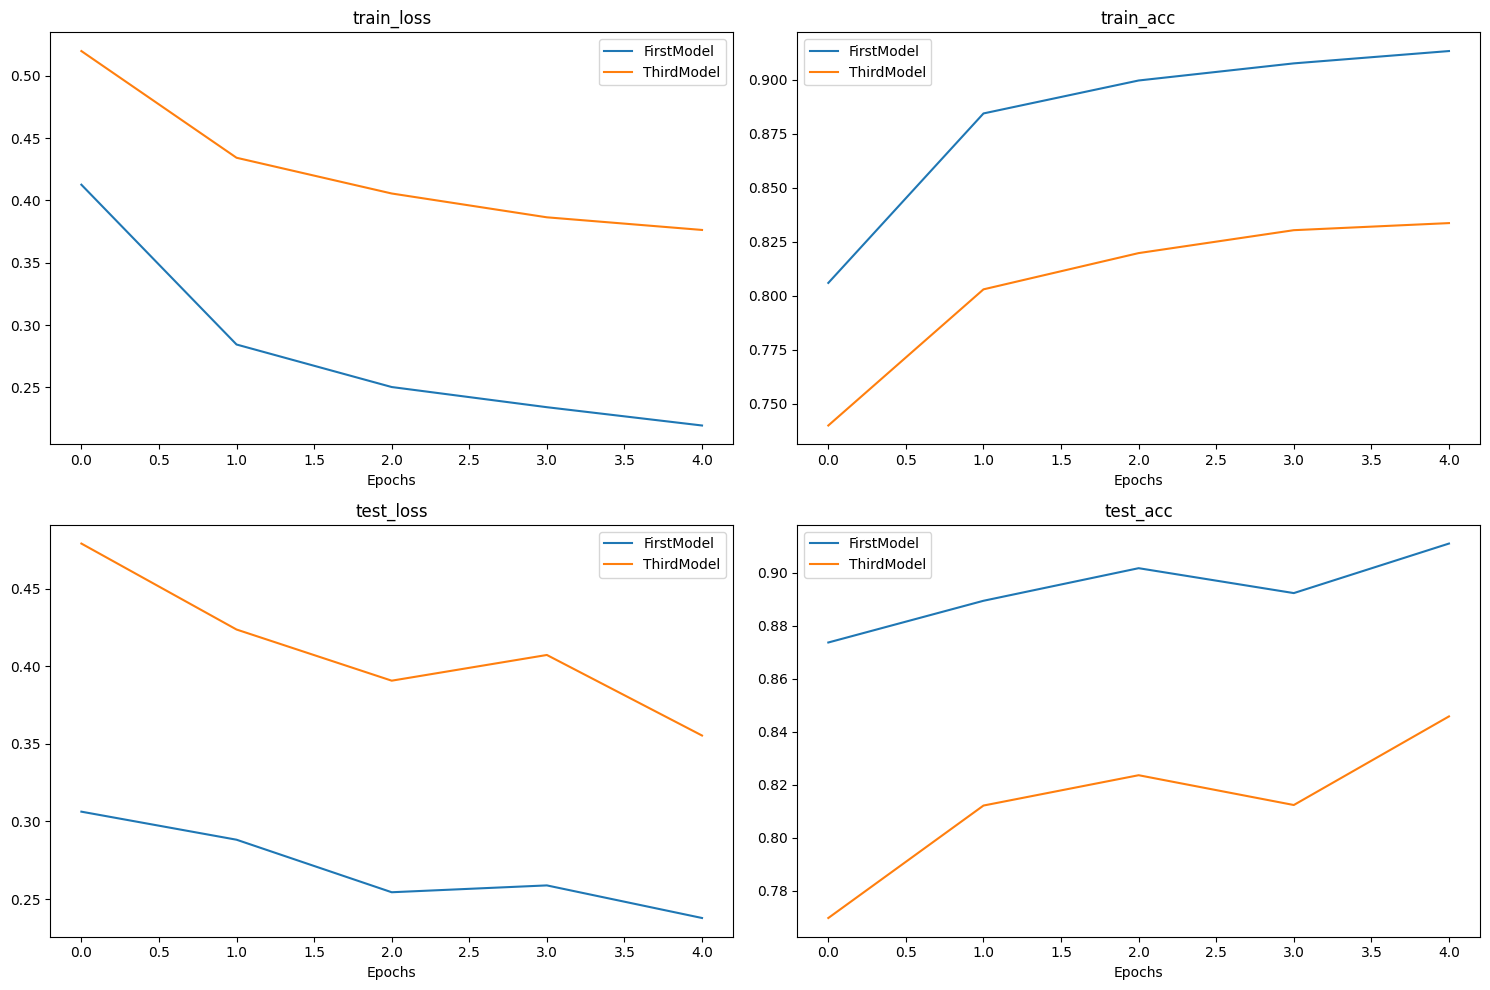

In [ ]:
plot_model_metrics([model_0_df, model_2_df], model_names=["FirstModel", "ThirdModel"])

Inference from the visual representations above unmistakably indicates that the performance of the `FirstModel` surpasses that of the `ThirdModel` in both training and testing phases.

### Fourth model ###

The fourth model will based on `DenseNet`' which is a deep neural network architecture known for its dense connectivity between layers.

For our task, we will use `DenseNet121` architecture

* DenseNet121 is a convolutional neural network architecture that is known for its densely connected layers. It's designed to enhance feature reuse and facilitate gradient flow during training. DenseNet121 has 121 layers and utilizes skip connections to connect all layers in a dense and efficient manner. This architecture is widely used for tasks such as image classification and object detection, and it has demonstrated strong performance in various computer vision applications.

Saving DenseNet121.jpg to DenseNet121.jpg


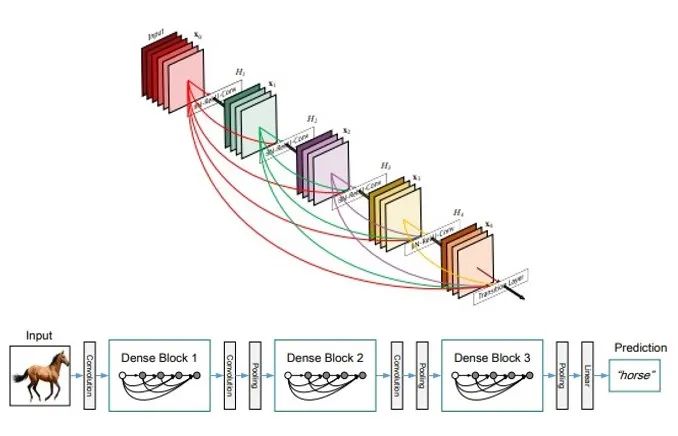

#### Creating transformer, dataset and DataLoader for the fourth model ####

In [ ]:
fourth_model_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

fourth_model_transform

Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [ ]:
from torch.utils.data import DataLoader

# Load and transform data
train_data_fom = datasets.ImageFolder(root=train_dir_path, transform=fourth_model_transform)
test_data_fom = datasets.ImageFolder(root=test_dir_path, transform=fourth_model_transform)

# Turn data into DataLoader
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers")

train_dataloader_fom = DataLoader(dataset=train_data_fom,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
test_dataloader_fom = DataLoader(dataset=test_data_fom,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=NUM_WORKERS)

train_dataloader_fom, test_dataloader_fom

Creating DataLoader's with batch size 32 and 40 workers


(<torch.utils.data.dataloader.DataLoader at 0x782bd0fc9ae0>,
 <torch.utils.data.dataloader.DataLoader at 0x782bd0fc93f0>)

#### Create fourth model ####

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        # Load the pre-trained DenseNet model
        self.densenet = models.densenet121(pretrained=False)

        # Replace the final classification layer
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.densenet(x)

In [ ]:
model_3 = DenseNet(len(train_data_fom.classes)).to(device)

#### Visualize DenseNet121 architecture ####

Use `summery()` method to visualize DenseNet model architecture that we build using `DenseNet121`

In [ ]:
summary(model_3, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [1, 2]                    --
├─DenseNet: 1-1                               [1, 2]                    --
│    └─Sequential: 2-1                        [1, 1024, 7, 7]           --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                         [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                    [1, 64, 56, 56]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 56, 56]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 28, 28]          33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 28, 28]          919,680
│    │    └─_Transition: 3-8                  [1, 256, 14, 14]          132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 14, 14]         

#### Train and evaluate fourth model ####

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()


model_3_res = train(model=model_3,
                        train_dataloader=train_dataloader_fom,
                        test_dataloader=test_dataloader_fom,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss 0.2980 | train_acc 0.8739 | test_loss 0.2256 | test_acc 0.9103 | 
Epoch: 2 | train_loss 0.1938 | train_acc 0.9233 | test_loss 0.1404 | test_acc 0.9455 | 
Epoch: 3 | train_loss 0.1545 | train_acc 0.9400 | test_loss 0.1349 | test_acc 0.9489 | 
Epoch: 4 | train_loss 0.1331 | train_acc 0.9489 | test_loss 0.1109 | test_acc 0.9575 | 
Epoch: 5 | train_loss 0.1182 | train_acc 0.9546 | test_loss 0.1056 | test_acc 0.9608 | 
Total training time: 2870.971 seconds


#### Conclusion for FourthModel ####

* The Fourth Model demonstrated superior performance, achieving the highest test accuracy (i.e. test_acc) among all four models with an impressive accuracy score of `0.9593`.

* However, this commendable performance comes at the cost of an extended training and evaluation time, taking a considerable *46 minutes*.

* Similar to the `SecondModel` which is based on the `ResNet50` architecture, the `FourthModel` utilizes the `DenseNet121` architecture. Notably, we set the hyperparameter pretrained to False, a decision that could contribute to the extended training and evaluation duration. This choice required us to train the model from scratch to obtain essential variables such as `train_acc`, `test_acc`, `train_loss`, and `test_loss` – variables that are not readily available in a pretrained model.



#### Plot loss and accuracy curves for visualization ####

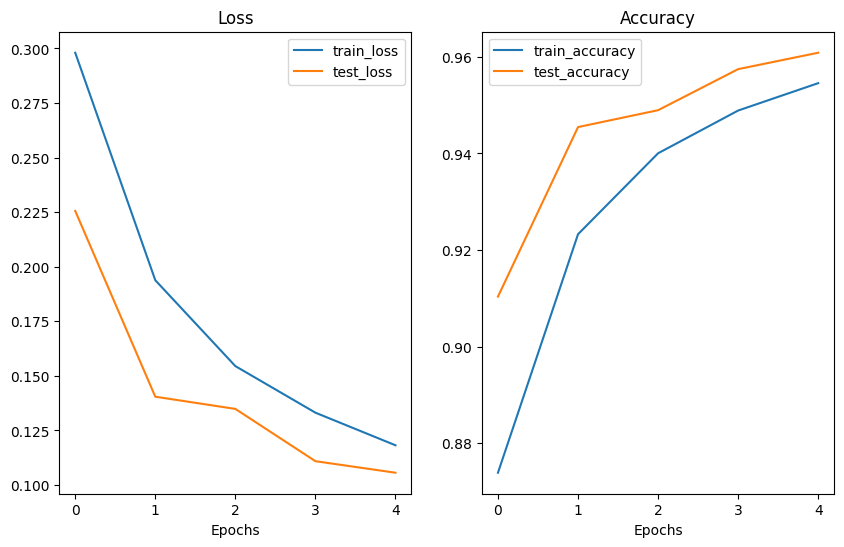

In [ ]:
plot_loss_curves(model_3_res)

## Compare all the models together ##

After developing four distinct computational models and subjecting them to training for a period of five epochs using our dataset, we propose the creation of a comprehensive visualization function. This function is designed to concurrently display the performance metrics of each model, thereby facilitating a thorough assessment of their suitability for our image classification task. By visually comparing these models, we aim to make informed decisions regarding their respective aptitude and effectiveness in addressing our specific classification requirements.

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_res)
model_1_df = pd.DataFrame(model_1_res)
model_2_df = pd.DataFrame(model_2_res)
model_3_df = pd.DataFrame(model_3_res)

We can employ the previously defined function (e.g. `plot_model_metrics()`) to facilitate the comparison between two models, referred to as `FirstModel` and `ThirdModel` This comparison allows us to discern discrepancies between these models, despite their striking architectural similarities

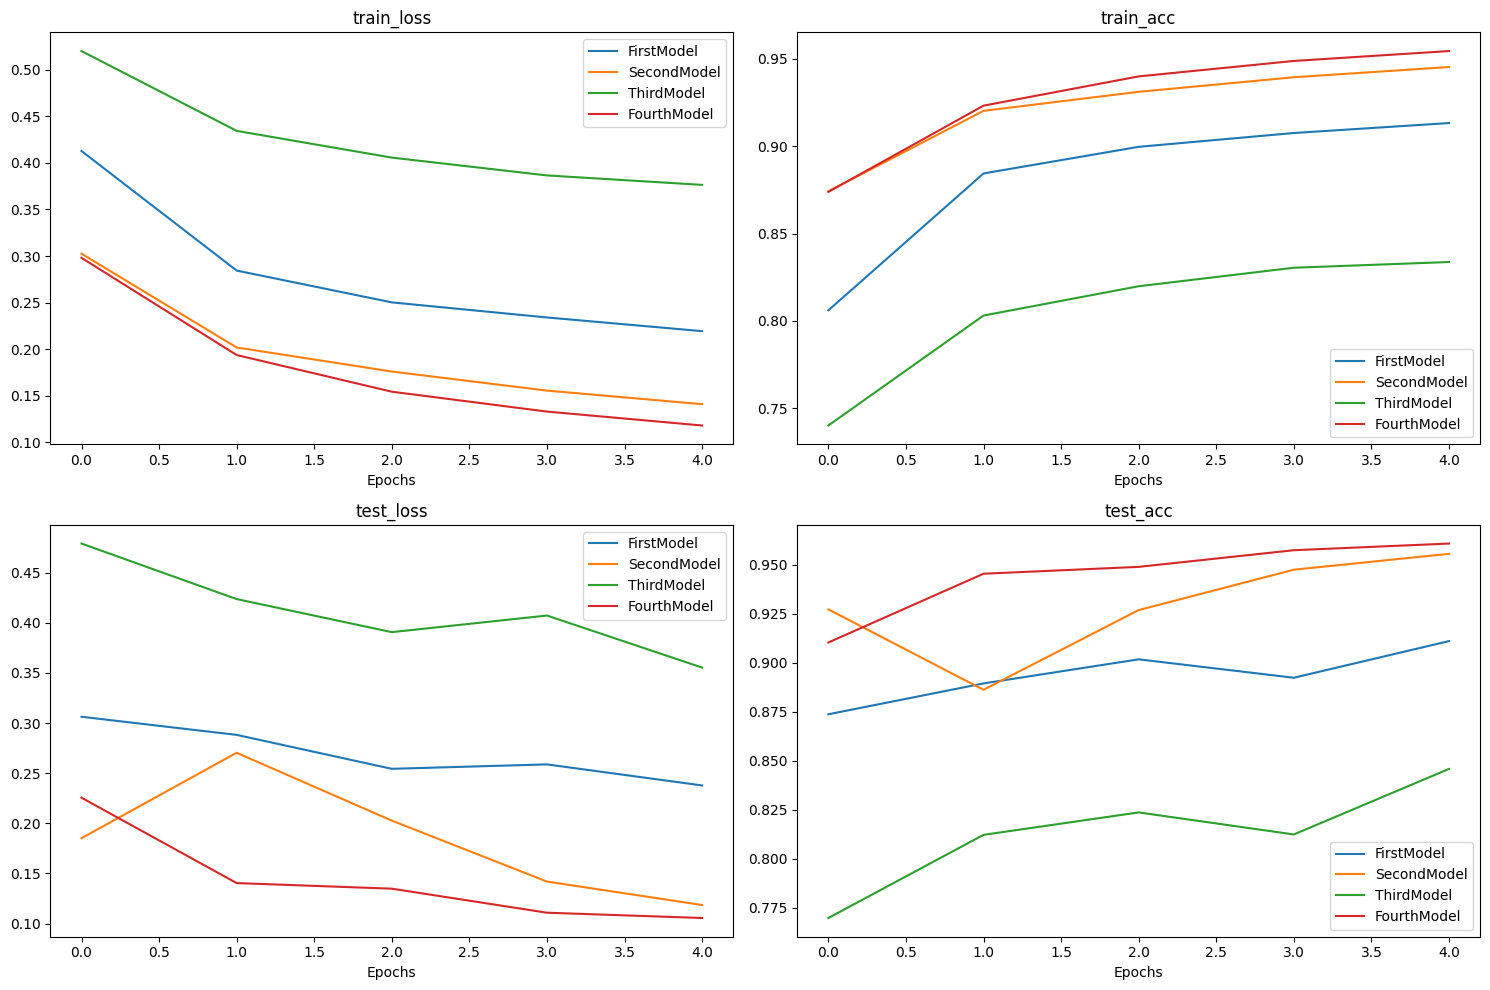

In [ ]:
plot_model_metrics([model_0_df, model_1_df, model_2_df, model_3_df], model_names=["FirstModel", "SecondModel", "ThirdModel", "FourthModel"])


### Conclusion ###

In conclusion, among the four models generated for the task of classifying fake AI images from real images, the `FourthModel`, which is built upon the `DenseNet121` architecture, exhibited superior performance. Notably, it achieved the highest test accuracy and lowest test loss when compared to the other three models. It is worth mentioning that the `FourthModel`'s training time was not the quickest among the four models, yet its exceptional test results underline its effectiveness in discerning between fake and real images. Therefore, for the specific classification task at hand, the `FourthModel`, leveraging the `DenseNet121` architecture, emerges as the most proficient choice.
